In [1]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, json, logging
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from pathlib import Path
from util import config_logger
from util import openH5File, encode4h5, parse_suffix, config_logger


import numpy as np, pandas as pd, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP
import anndata as ad

import scanpy as sc

import torch
torch.set_num_threads(16)
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

from matplotlib import pyplot as plt
from load_data import load_expression, load_edges, load_genelist

import seaborn as sns
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

logger = config_logger(logging.getLogger(__name__))

In [2]:
df_counts = pd.read_csv('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/features_and_metadata.csv')
df_counts.head()

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,...,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin,cluster.term
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,...,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827,B
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,...,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198,DC
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,...,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686,NK
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,...,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151,Monocyte
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,...,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000,CD4


In [3]:
cellpop = np.load('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/feature_labels_res0.5.npy')
df_counts['cellpop'] = cellpop

In [5]:
save_path = "../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/files/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

## directly only saving the top 50k cells for time saving

In [6]:
features_names = [
        'CD2', 'CD56',
        'CD20', 'CD30', 'CD31', 'CD4', 
        'CD57',  'CD7', 'CD8',
        'Granzyme.B','FoxP3', 'CD11c', 'CD16', 'CD206', 'CD163', 'CD68', 'CD15', 'CD11b',
        'MCT', 'Cytokeratin', 
        'Podoplanin', 'a.SMA'
    ]

#np.savetxt(os.path.join(save_path, f"expression_chl.txt"), df_counts.loc[:50000,features_names]) #####
np.savetxt(os.path.join(save_path, f"expression_chlfull.txt"), df_counts.loc[:,features_names])

# save neighborhood
#locations = df_counts.loc[:50000,['X_cent', 'Y_cent']].to_numpy()
#adata = ad.AnnData(df_counts.loc[:50000,features_names], dtype=np.float32)
locations = df_counts.loc[:,['X_cent', 'Y_cent']].to_numpy()
adata = ad.AnnData(df_counts.loc[:,features_names], dtype=np.float32)

adata.obsm["spatial"] = locations
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=None, use_rep='spatial')
rows, cols = adata.obsp['connectivities'].nonzero()
edges = np.array([rows, cols]).T

#file = open(os.path.join(save_path, f"neighborhood_chl.txt"),'w') ######
file = open(os.path.join(save_path, f"neighborhood_chlfull.txt"),'w')
for i in range(rows.shape[0]):
    file.write(str(rows[i])+" "+str(cols[i])+"\n")
file.close()

# save cell type
#file = open(os.path.join(save_path, f"genes_chl.txt"),'w') #####
file = open(os.path.join(save_path, f"genes_chlfull.txt"),'w') #####

for item in features_names:
    file.write(item+"\n")
file.close()

#file = open(os.path.join(save_path, f"celltypes_chl.txt"),'w') # note this does not have human intervention annotaion
file = open(os.path.join(save_path, f"celltypes_chl.txt"),'w') # note this does not have human intervention annotaion
for i in range(df_counts.shape[0]):
    file.write(df_counts.loc[:,'cellpop'].astype(str)[i] + "\n")
file.close()

/home/bokai/miniconda3/envs/spicemix/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### spicemix start running

In [6]:
# -- specify device
context = dict(device='cpu', dtype=torch.float64)
# context = dict(device='cpu', dtype=torch.float64)
context_Y = context
# -- specify dataset
path2dataset = Path('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/')
#repli_list = list(df['fov'].unique().astype(str))
repli_list = ['chlfull']

In [8]:
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

np.random.seed(0)

K, num_pcs, n_neighbors, res_lo, res_hi = 20, 20, 15, .5, 2.

path2result = path2dataset / 'results' / 'SpiceMix.h5'
os.makedirs(path2result.parent, exist_ok=True)
if os.path.exists(path2result):
    os.remove(path2result)
    
obj = SpiceMix(
    K=K,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    path2result=path2result,
)
obj.load_dataset(path2dataset)

2024-02-02 10:22:29:INFO:result file = ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/results/SpiceMix.h5
2024-02-02 10:22:31:INFO:Loaded 143730 cells and 22 genes from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/files/expression_chlfull.txt
2024-02-02 10:22:31:INFO:Loaded 22 genes from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/files/genes_chlfull.txt
2024-02-02 10:22:38:WARNING:Detected 1084080 duplicate edge(s) from 2168160 loaded edges. Duplicate edges are discarded.
2024-02-02 10:22:39:INFO:Loaded 1084080 edges from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_use_full/files/neighborhood_chlfull.txt


In [ ]:
obj.meta['cell type'] = pd.Categorical(obj.meta['cell type'])
obj.initialize(
    method='louvain', kwargs=dict(num_pcs=num_pcs, n_neighbors=n_neighbors, resolution_boundaries=(res_lo, res_hi), num_rs = 2),
)
for iiter in range(200):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
obj.initialize_Sigma_x_inv()

In [10]:
latent_states = [X.cpu().numpy() for X in obj.Xs]
latent_state_cat = np.concatenate(latent_states, axis=0)

/home/bokai/miniconda3/envs/spicemix/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


<AxesSubplot:title={'center':'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

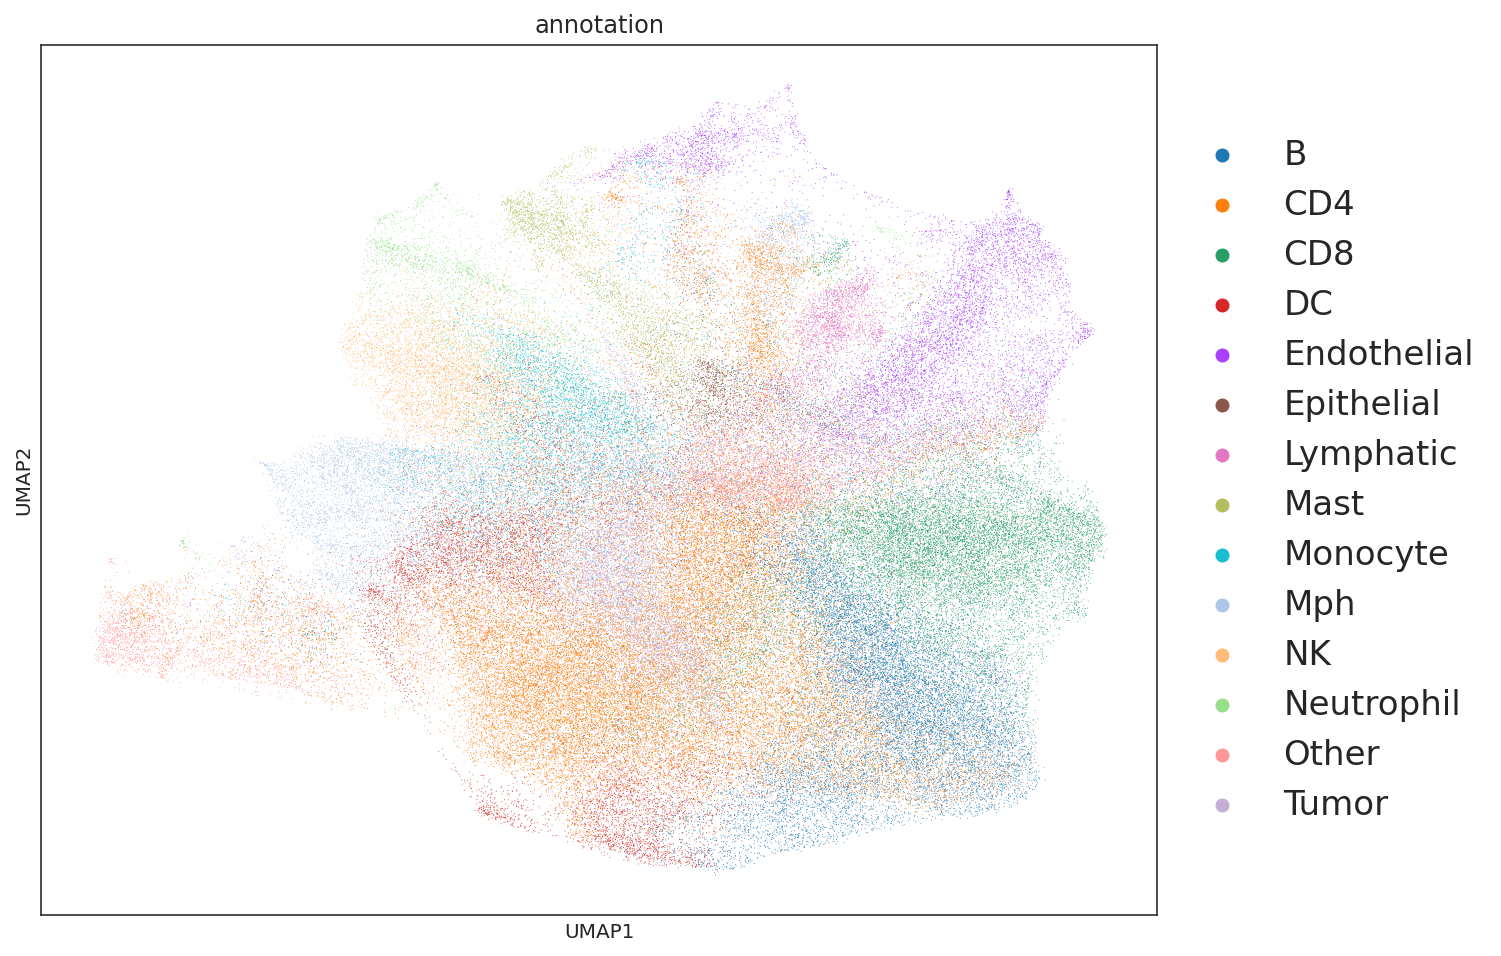

In [11]:
# full feature embeddings
feature_adata = ad.AnnData(latent_state_cat)
sc.pp.scale(feature_adata)
feature_adata.obs['annotation'] = list(df_counts.loc[:,'cluster.term'])
sc.tl.pca(feature_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(feature_adata, n_neighbors=10)
sc.tl.umap(feature_adata)
plt.rcParams["figure.figsize"] = (10,8)
sc.pl.umap(feature_adata, color='annotation', legend_fontsize=17, show=False)

In [12]:
np.save('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/cHL_codex/data/spicemix_chlfull_embedding.npy', latent_state_cat) 
print('done')

done


In [13]:
latent_state_cat.shape

(143730, 20)